Loading OSM graph (this may take a few seconds)...
Nodes: 1439, Edges: 2075
Saving GIF (this can take some seconds)...
Saved: simulation.gif


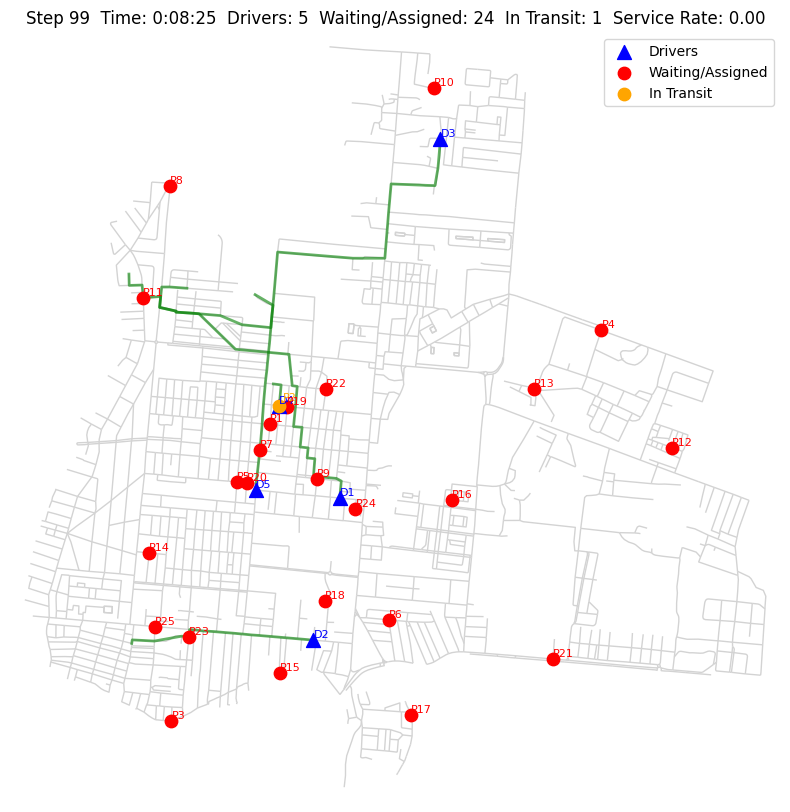

In [38]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import math
import re
import numpy as np
from datetime import timedelta

# -----------------------------
# CONFIG
# -----------------------------
PLACE = "Bordj El Bahri, Algeria"
NUM_DRIVERS = 5
CAPACITY = 3  # Max passengers per taxi
NUM_INITIAL_PASSENGERS = 3
SPAWN_RATE = 0.2
DETOUR_MAX = 1.2  # +20% distance
MAX_WAIT = 300.0  # Seconds max wait
SPEED_FACTOR = 4.0
DT = 5
FRAMES = 100
GIF_OUTPUT = "simulation.gif"
CURRENT_TIME = 0.0

# -----------------------------
# Utility Functions
# -----------------------------
def haversine_m(lat1, lon1, lat2, lon2):
    R = 6371000.0
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    return 2*R*math.asin(math.sqrt(a))

def get_edge_attr(G, u, v):
    ed = G.get_edge_data(u, v)
    if ed is None:
        return None
    if 'length' in ed or 'maxspeed' in ed:
        return ed
    if isinstance(ed, dict):
        for val in ed.values():
            if isinstance(val, dict):
                return val
    return ed

def parse_maxspeed(val):
    if val is None:
        return None
    if isinstance(val, (list, tuple)):
        val = val[0]
    s = str(val)
    m = re.search(r'(\d+(\.\d+)?)', s)
    if m:
        try:
            return float(m.group(1))
        except:
            return None
    return None

def get_edge_speed_m_s(G, u, v, default_kmh=50.0):
    attr = get_edge_attr(G, u, v)
    if attr is None:
        return default_kmh * 1000.0 / 3600.0
    ms = None
    if 'maxspeed' in attr:
        ms = parse_maxspeed(attr['maxspeed'])
    if ms is None:
        return default_kmh * 1000.0 / 3600.0
    return ms * 1000.0 / 3600.0

def get_edge_length_m(G, u, v):
    attr = get_edge_attr(G, u, v)
    if attr and 'length' in attr and attr['length'] is not None:
        try:
            return float(attr['length'])
        except:
            pass
    x1, y1 = G.nodes[u]['y'], G.nodes[u]['x']
    x2, y2 = G.nodes[v]['y'], G.nodes[v]['x']
    return haversine_m(x1, y1, x2, y2)

def get_edge_time_s(G, u, v):
    length = get_edge_length_m(G, u, v)
    speed = get_edge_speed_m_s(G, u, v)
    return length / speed if speed > 0 else float('inf')

def route_distance(G, route):
    dist = 0.0
    for i in range(len(route) - 1):
        dist += get_edge_length_m(G, route[i], route[i+1])
    return dist

def route_time(G, route):
    time = 0.0
    for i in range(len(route) - 1):
        time += get_edge_time_s(G, route[i], route[i+1])
    return time

# -----------------------------
# Load Graph
# -----------------------------
print("Loading OSM graph (this may take a few seconds)...")
G = ox.graph_from_place(PLACE, network_type="drive")
G = G.to_undirected()
nodes = list(G.nodes)
print(f"Nodes: {len(nodes)}, Edges: {len(G.edges)}")

# -----------------------------
# Initialize Drivers and Passengers
# -----------------------------
drivers = []
for i in range(NUM_DRIVERS):
    n = random.choice(nodes)
    drivers.append({
        "id": f"D{i+1}",
        "node": n,
        "pos": (G.nodes[n]['x'], G.nodes[n]['y']),
        "route": [n],
        "route_types": ['start'],
        "route_passengers": [None],
        "onboard": [],
        "assigned": [],
        "edge": None,
        "progress": 0.0
    })

passengers = []
for i in range(NUM_INITIAL_PASSENGERS):
    o = random.choice(nodes)
    d = random.choice(nodes)
    while o == d:
        d = random.choice(nodes)
    passengers.append({
        "id": f"P{i+1}",
        "origin": o,
        "dest": d,
        "status": "waiting",
        "request_time": 0.0
    })

def concat_route_safe(G, waypoints):
    full = []
    try:
        for a, b in zip(waypoints[:-1], waypoints[1:]):
            sub = nx.shortest_path(G, a, b, weight="length")
            if full and full[-1] == sub[0]:
                full += sub[1:]
            else:
                full += sub
        return full
    except (nx.NetworkXNoPath, nx.NodeNotFound):
        return []

for drv in drivers:
    target = random.choice(nodes)
    route = concat_route_safe(G, [drv["node"], target])
    if len(route) > 1:
        drv["route"] = route
        drv["route_types"] = ['start'] + ['end'] * (len(route) - 1)
        drv["route_passengers"] = [None] * len(route)

# -----------------------------
# Passenger Assignment
# -----------------------------
def insert_passenger(G, drv, p, current_time):
    origin = p["origin"]
    dest = p["dest"]
    direct_dist = route_distance(G, concat_route_safe(G, [origin, dest]))
    direct_time = route_time(G, concat_route_safe(G, [origin, dest]))
    best_added = float('inf')
    best_i = best_j = -1
    best_new_route = None
    current_route = drv["route"]
    n_stops = len(current_route)
    for i in range(n_stops):
        for j in range(i+1, n_stops+1):
            new_route = current_route[:i+1] + [origin] + current_route[i+1:j] + [dest] + current_route[j:]
            onboard_count = len(drv["onboard"])  # Start with current onboard
            max_onboard = onboard_count
            feasible = True
            for k in range(1, len(new_route)):
                if new_route[k] == origin:
                    onboard_count += 1
                elif new_route[k] == dest:
                    onboard_count -= 1
                max_onboard = max(max_onboard, onboard_count)
                if max_onboard > CAPACITY:
                    feasible = False
                    break
            if not feasible:
                continue
            new_dist = route_distance(G, new_route)
            old_dist = route_distance(G, current_route)
            added_dist = new_dist - old_dist
            if added_dist > (DETOUR_MAX - 1) * direct_dist:
                continue
            time_to_pickup = route_time(G, new_route[:i+2])
            estimated_wait = time_to_pickup + (current_time - p["request_time"])
            if estimated_wait > MAX_WAIT:
                continue
            if added_dist < best_added:
                best_added = added_dist
                best_i = i
                best_j = j
                best_new_route = new_route
    return best_added, best_new_route, best_i, best_j

def assign_passengers(G, drivers, passengers, current_time):
    waiting = [p for p in passengers if p["status"] == "waiting"]
    for p in waiting:
        best_drv = None
        best_added = float('inf')
        best_new_route = None
        best_i = best_j = -1
        for drv in drivers:
            if len(drv["onboard"]) + len(drv["assigned"]) >= CAPACITY:
                continue
            added, new_route, i, j = insert_passenger(G, drv, p, current_time)
            if added < best_added:
                best_added = added
                best_drv = drv
                best_new_route = new_route
                best_i = i
                best_j = j
        if best_drv is not None:
            best_drv["route"] = best_new_route
            best_drv["route_types"] = best_drv["route_types"][:best_i+1] + ['pickup'] + best_drv["route_types"][best_i+1:best_j] + ['dropoff'] + best_drv["route_types"][best_j:]
            best_drv["route_passengers"] = best_drv["route_passengers"][:best_i+1] + [p["id"]] + best_drv["route_passengers"][best_i+1:best_j] + [p["id"]] + best_drv["route_passengers"][best_j:]
            p["status"] = "assigned"
            best_drv["assigned"].append(p["id"])

# -----------------------------
# Visualization and Animation
# -----------------------------
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_axis_off()
ox.plot_graph(G, ax=ax, node_size=0, edge_color="lightgray", show=False, close=False)
ax.grid(True, linestyle='--', alpha=0.3)

driver_scatter = ax.scatter([d["pos"][0] for d in drivers],
                           [d["pos"][1] for d in drivers],
                           c='blue', s=100, marker='^', zorder=4, label='Drivers')
passenger_scatter = ax.scatter([], [], c='red', s=80, marker='o', zorder=3, label='Waiting/Assigned')
in_transit_scatter = ax.scatter([], [], c='orange', s=80, marker='o', zorder=5, label='In Transit')
temp_artists = []
driver_labels = []
passenger_labels = []

ax.legend(loc='upper right')

def move_driver_step(G, driver, dt=DT, speed_factor=SPEED_FACTOR):
    if driver["edge"] is None and len(driver["route"]) > 1:
        next_node = driver["route"][1]
        if G.has_edge(driver["node"], next_node):
            driver["edge"] = (driver["node"], next_node)
            driver["progress"] = 0.0
        else:
            driver["route"] = driver["route"][1:]
            driver["route_types"] = driver["route_types"][1:]
            driver["route_passengers"] = driver["route_passengers"][1:]
            return

    if driver["edge"] is None:
        if not driver["route"][1:]:
            target = random.choice(nodes)
            driver["route"] = concat_route_safe(G, [driver["node"], target])
            driver["route_types"] = ['start'] + ['end'] * (len(driver["route"]) - 1)
            driver["route_passengers"] = [None] * len(driver["route"])
        return

    u, v = driver["edge"]
    if not G.has_edge(u, v):
        driver["edge"] = None
        driver["route"] = driver["route"][1:]
        driver["route_types"] = driver["route_types"][1:]
        driver["route_passengers"] = driver["route_passengers"][1:]
        return

    length = get_edge_length_m(G, u, v)
    speed = get_edge_speed_m_s(G, u, v) * speed_factor
    travel = speed * dt

    driver["progress"] += travel
    if driver["progress"] >= length:
        driver["node"] = v
        driver["pos"] = (G.nodes[v]['x'], G.nodes[v]['y'])
        driver["progress"] = 0.0
        if len(driver["route"]) > 1:
            if driver["route_types"][1] == 'pickup':
                p_id = driver["route_passengers"][1]
                if p_id in driver["assigned"]:
                    driver["onboard"].append(p_id)
                    driver["assigned"].remove(p_id)
                    for p in passengers:
                        if p["id"] == p_id:
                            p["status"] = "in_transit"
                            break
            elif driver["route_types"][1] == 'dropoff':
                p_id = driver["route_passengers"][1]
                if p_id in driver["onboard"]:  # Check if passenger is onboard
                    driver["onboard"].remove(p_id)
                    for p in passengers:
                        if p["id"] == p_id:
                            p["status"] = "dropped"
                            p["drop_frame"] = frame
                            break
            driver["route"] = driver["route"][1:]
            driver["route_types"] = driver["route_types"][1:]
            driver["route_passengers"] = driver["route_passengers"][1:]
        driver["edge"] = None
    else:
        x1, y1 = G.nodes[u]['x'], G.nodes[u]['y']
        x2, y2 = G.nodes[v]['x'], G.nodes[v]['y']
        ratio = driver["progress"] / length
        driver["pos"] = (x1 + (x2 - x1) * ratio, y1 + (y2 - y1) * ratio)

def update(frame):
    global CURRENT_TIME, temp_artists, driver_labels, passenger_labels
    CURRENT_TIME += DT
    for art in temp_artists:
        try:
            art.remove()
        except:
            pass
    for lbl in driver_labels + passenger_labels:
        try:
            lbl.remove()
        except:
            pass
    temp_artists = []
    driver_labels = []
    passenger_labels = []

    if random.random() < SPAWN_RATE:
        o = random.choice(nodes)
        d = random.choice(nodes)
        while o == d:
            d = random.choice(nodes)
        passengers.append({"id": f"P{len(passengers)+1}", "origin": o, "dest": d, "status": "waiting", "request_time": CURRENT_TIME})

    assign_passengers(G, drivers, passengers, CURRENT_TIME)

    for drv in drivers:
        move_driver_step(G, drv)

    dx = [drv["pos"][0] for drv in drivers]
    dy = [drv["pos"][1] for drv in drivers]
    driver_scatter.set_offsets(list(zip(dx, dy)))

    wait_xy = [(G.nodes[p["origin"]]['x'], G.nodes[p["origin"]]['y']) for p in passengers if p["status"] in ["waiting", "assigned"]]
    if wait_xy:
        passenger_scatter.set_offsets(wait_xy)
    else:
        passenger_scatter.set_offsets(np.empty((0, 2)))

    in_transit_xy = [drv["pos"] for drv in drivers for _ in drv["onboard"]]
    if in_transit_xy:
        in_transit_scatter.set_offsets(in_transit_xy)
    else:
        in_transit_scatter.set_offsets(np.empty((0, 2)))

    for p in [pp for pp in passengers if pp["status"] == "dropped"]:
        if "drop_frame" in p:
            frames_since_drop = frame - p["drop_frame"]
            if frames_since_drop <= 5:
                alpha = max(0, 1 - frames_since_drop / 5.0)
                px, py = G.nodes[p["dest"]]['x'], G.nodes[p["dest"]]['y']
                sc = ax.scatter(px, py, c='green', s=80, marker='o', alpha=alpha, zorder=3)
                temp_artists.append(sc)
                lbl = ax.text(px, py + 0.0001, p["id"], fontsize=8, color='green', alpha=alpha, zorder=5)
                passenger_labels.append(lbl)

    for drv in drivers:
        if len(drv["route"]) > 1:
            coords = [(G.nodes[n]['x'], G.nodes[n]['y']) for n in drv["route"]]
            xs, ys = zip(*coords)
            ln, = ax.plot(xs, ys, color='green', linewidth=2, alpha=0.6, zorder=2)
            temp_artists.append(ln)
        dlbl = ax.text(drv["pos"][0], drv["pos"][1] + 0.0001, drv["id"], fontsize=8, color='blue', zorder=5)
        driver_labels.append(dlbl)
        for idx, p_id in enumerate(drv["onboard"]):
            plbl = ax.text(drv["pos"][0] + 0.0002 * (idx + 1), drv["pos"][1] + 0.0002 * (idx + 1), p_id, fontsize=8, color='orange', zorder=5)
            passenger_labels.append(plbl)

    for pp in [pp for pp in passengers if pp["status"] in ["waiting", "assigned"]]:
        px, py = G.nodes[pp["origin"]]['x'], G.nodes[pp["origin"]]['y']
        plbl = ax.text(px, py + 0.0001, pp["id"], fontsize=8, color='red', zorder=5)
        passenger_labels.append(plbl)

    passengers[:] = [p for p in passengers if not (p["status"] == "dropped" and "drop_frame" in p and frame - p["drop_frame"] > 5)]

    served = len([p for p in passengers if p["status"] == "dropped"])
    total_requests = len(passengers) + served
    service_rate = served / total_requests if total_requests > 0 else 0
    ax.set_title(f"Step {frame}  Time: {timedelta(seconds=int(CURRENT_TIME))}  Drivers: {len(drivers)}  Waiting/Assigned: {len(wait_xy)}  In Transit: {len(in_transit_xy)}  Service Rate: {service_rate:.2f}")
    return [driver_scatter, passenger_scatter, in_transit_scatter] + temp_artists + driver_labels + passenger_labels

anim = animation.FuncAnimation(fig, update, frames=FRAMES, interval=300, blit=False, repeat=False)

print("Saving GIF (this can take some seconds)...")
anim.save(GIF_OUTPUT, writer=animation.PillowWriter(fps=6))
print("Saved:", GIF_OUTPUT)

plt.show()